In [43]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [44]:
#文件的路径
sample_path = "~/Desktop/Cases_1/苏州工业园/Electric power load data/2016/1_hour/2016_1hour_Residential/20160101_1hour_Residential.xlsx"
sample_path = os.path.expanduser(sample_path)

# 读取文件头部几行
df = pd.read_excel(sample_path)
print("列名如下：")
print(df.columns)

# 设置文件夹路径
folder_path = os.path.expanduser("~/Desktop/Cases_1/苏州工业园/Electric power load data/2016/1_hour/2016_1hour_Residential")

# 获取所有 .xlsx 文件
file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.xlsx')])

# 创建空 DataFrame 用于合并
combined_df = pd.DataFrame()

# 遍历每个文件
for filename in file_list:
    try:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_excel(file_path, engine='openpyxl')  # 显式指定 engine
        
        # 标准化列名
        df.columns = [col.strip().replace('\n', '').replace('\r', '').lower() for col in df.columns]
        #  print(f"✔ 读取 {filename} 的列名为：{df.columns.tolist()}"

        # 判断列名是否存在
        if 'time' in df.columns and 'power (kw)' in df.columns:
            df = df[['time', 'power (kw)']]
            df['SourceFileDate'] = filename[:8]
            
            # 转换类型
            df['time'] = pd.to_datetime(df['time'])
            df['SourceFileDate'] = pd.to_datetime(df['SourceFileDate'])
            
            combined_df = pd.concat([combined_df, df], ignore_index=True)
        else:
            raise ValueError("列名不符合预期：'time' 和 'power (kw)' 不存在")
    
    except Exception as e:
        print(f"跳过文件 {filename}, 原因: {e}")


# 保存最终合并的 CSV
combined_df.to_csv("Residential_2016_1hour_long.csv", index=False)
print("成功导出为 'Residential_2016_1hour_long.csv'")

列名如下：
Index(['Time', 'Power (kW)'], dtype='object')
成功导出为 'Residential_2016_1hour_long.csv'


In [45]:
df = pd.read_csv("Residential_2016_1hour_long.csv", encoding='utf-8-sig')
df.columns = [col.strip().lower() for col in df.columns]  # 统一小写 + 去空格

# 统一时间格式
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date
df['hour'] = df['time'].dt.time

# 去重，只保留第一条记录
df = df.drop_duplicates(subset=['date', 'hour'], keep='first')

# 生成每天一行，每小时一列的负载矩阵
pivot_df = df.pivot(index='date', columns='hour', values='power (kw)').reset_index()
pivot_df.to_csv("daily_load_matrix_2016_1hour_Residential.csv", index=False)

print("已成功生成 daily_load_matrix_2016_1hour_Residential.csv（重复已处理）")

已成功生成 daily_load_matrix_2016_1hour_Residential.csv（重复已处理）


In [46]:
pivot_df = pd.read_csv("daily_load_matrix_2016_1hour_Residential.csv")
# 插值 + 双向填充
pivot_df_interp = pivot_df.set_index('date')
pivot_df_interp = pivot_df_interp.interpolate(axis=1, limit_direction='both')
pivot_df_interp = pivot_df_interp.ffill(axis=1).bfill(axis=1)

# 丢掉真的没救的数据（全为空行）
pivot_df_interp = pivot_df_interp.dropna(thresh=10)  # 至少保留10小时数据
pivot_df_interp = pivot_df_interp.reset_index()

In [47]:
pivot_df_interp.shape     
pivot_df_interp.head()

,date,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
0,2016-01-01,392.40,356.92,305.00,284.57,262.47,259.70,222.85,217.27,248.55,...,261.20,270.85,269.60,295.70,341.45,380.62,392.20,423.70,386.83,413.03
1,2016-01-02,383.37,332.60,291.15,263.70,243.60,242.00,205.33,212.70,228.00,...,236.07,248.60,251.85,260.93,350.60,327.50,344.00,356.80,374.80,361.20
2,2016-01-03,355.55,327.60,271.70,239.80,244.77,224.10,194.85,193.00,215.33,...,255.60,268.20,276.20,283.40,354.25,329.00,374.10,416.35,413.60,417.51
3,2016-01-04,347.90,290.40,288.00,243.30,226.70,218.60,201.30,214.85,245.20,...,225.60,222.30,225.85,257.50,293.95,358.20,376.80,412.20,420.60,439.53
4,2016-01-05,406.00,312.45,276.17,247.51,232.75,237.93,209.87,221.50,281.50,...,254.30,263.30,279.30,285.00,367.14,396.00,431.36,453.40,487.20,471.80


In [48]:
X = pivot_df_interp.select_dtypes(include='number')
print(X.isna().sum().sum())  # 输出所有 NaN 的总数


0


In [49]:
X = pivot_df_interp.select_dtypes(include='number')  # 数值型列，即每小时负载值
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

pivot_df_interp['cluster'] = clusters  # 添加聚类标签

# 正确保存
pivot_df_interp.to_csv("daily_load_with_clusters_and_labels_2016_Residential.csv", index=False)

In [50]:
print(pivot_df_interp[['date', 'cluster']].head())

         date  cluster
0  2016-01-01        0
1  2016-01-02        0
2  2016-01-03        0
3  2016-01-04        0
4  2016-01-05        0


In [57]:

cluster_name_map = {
    0: "low_load",
    1: "high_load",
    2: "high_morning_low_afternoon"
}

pivot_df_interp['pattern'] = pivot_df_interp['cluster'].map(cluster_name_map)

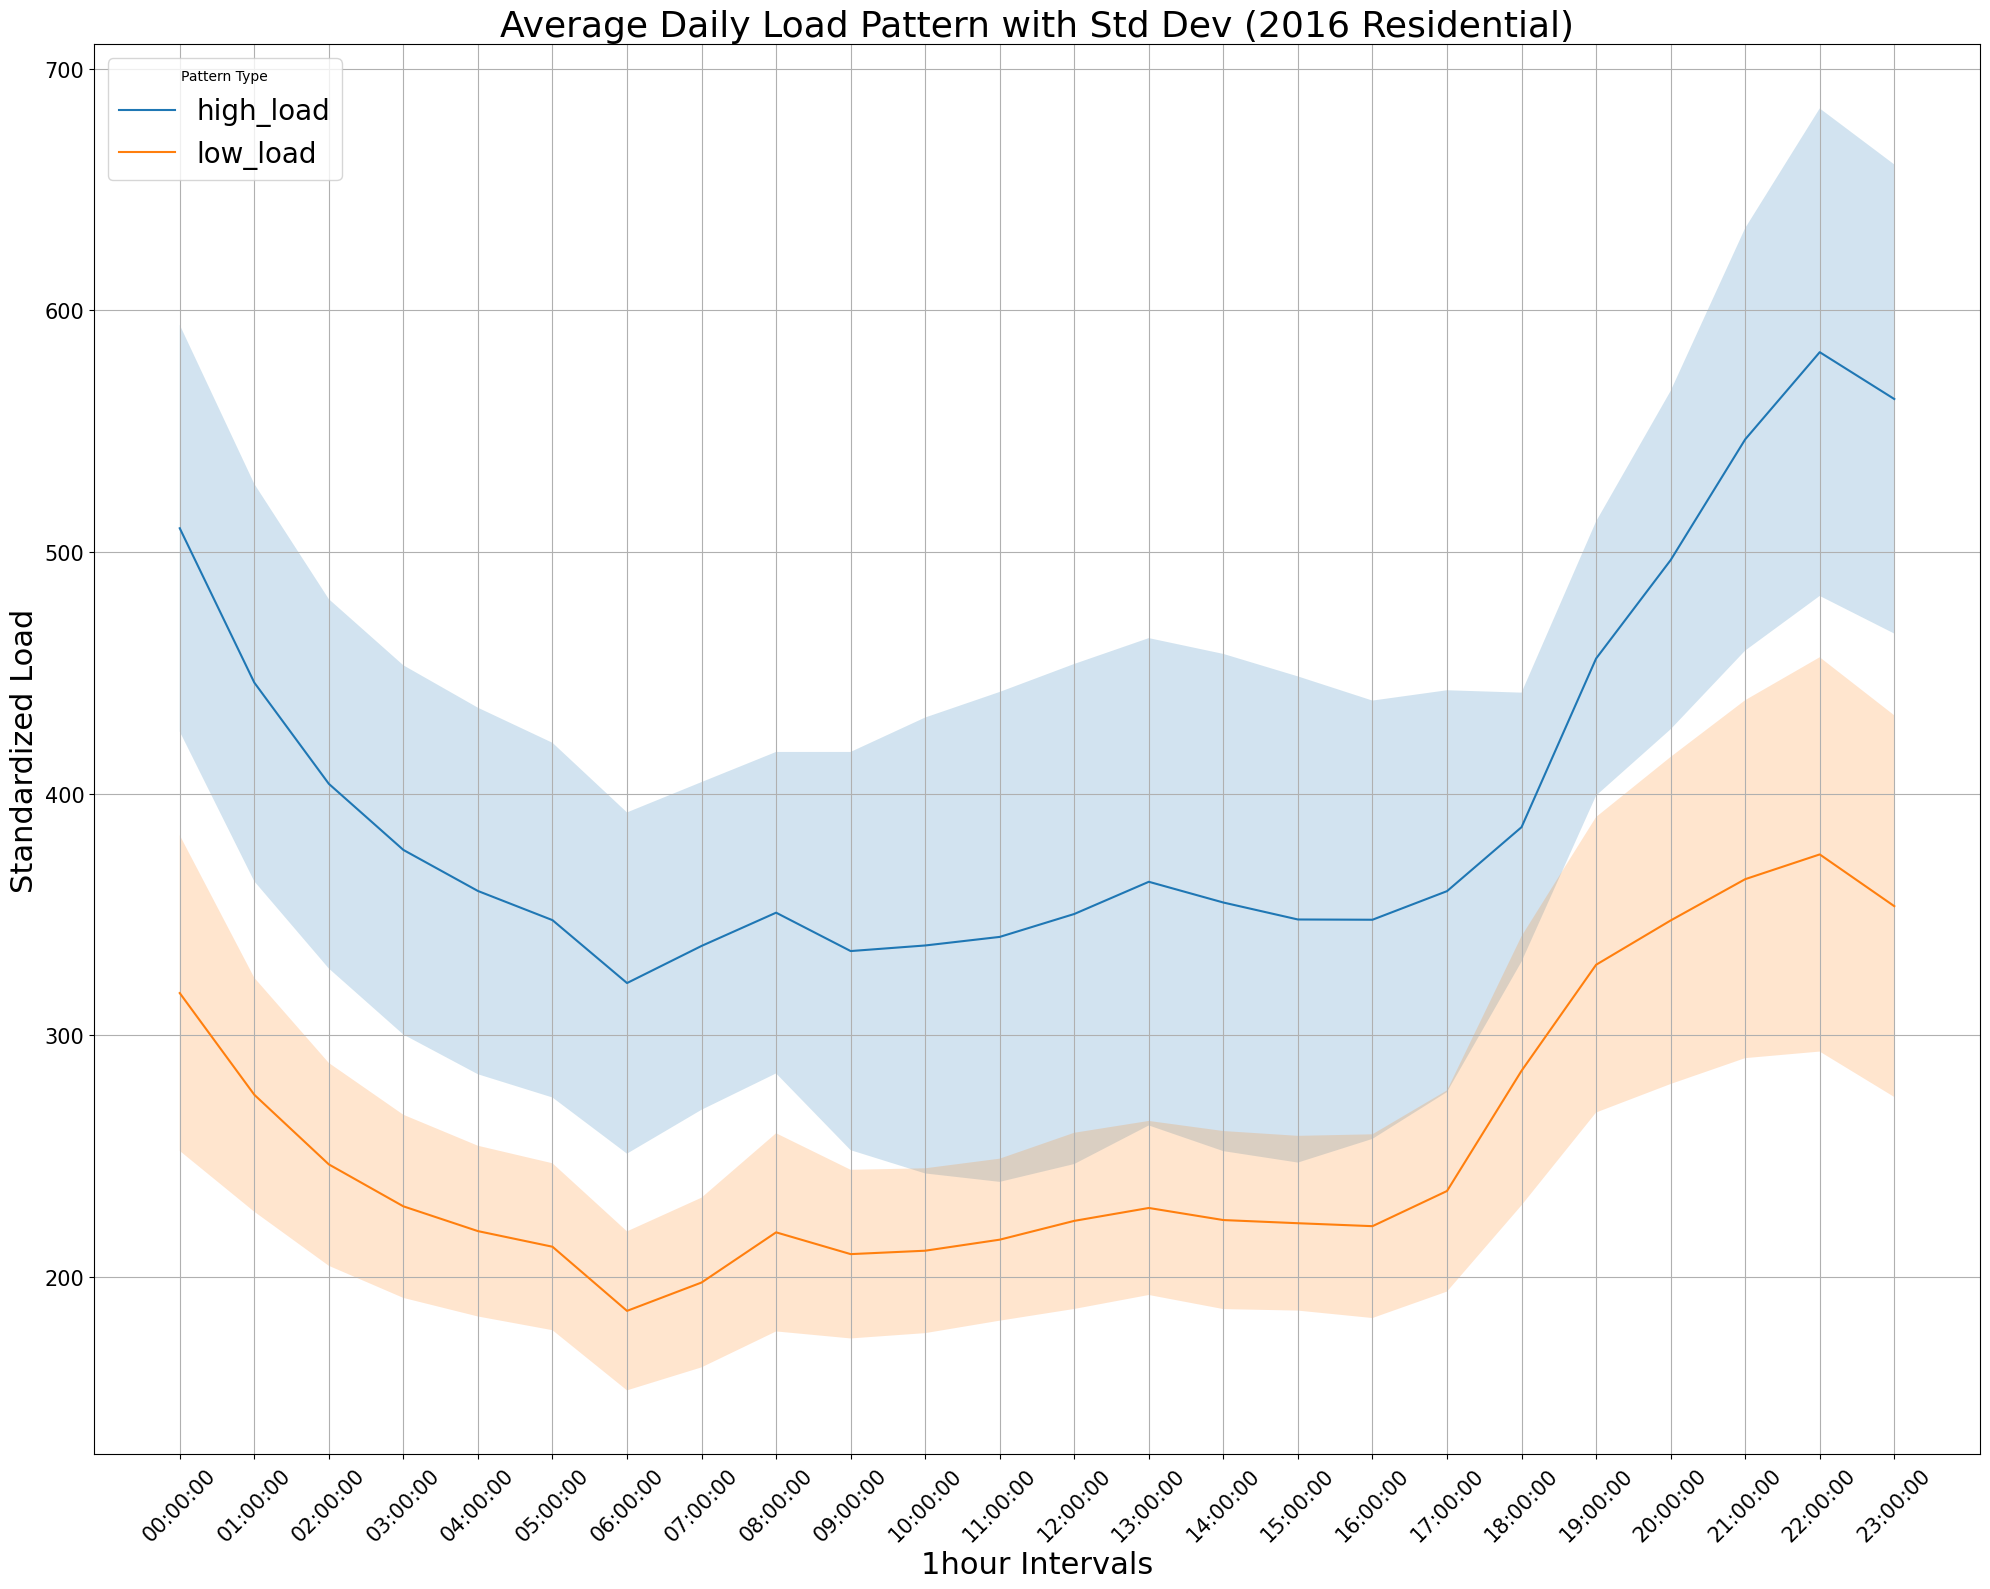

In [58]:
# ：确保只选取数值型列作为负载列
load_columns = pivot_df_interp.select_dtypes(include='number').columns
load_columns = [col for col in load_columns if col not in ['cluster']]  

# 计算均值和标准差
mean_by_label = pivot_df_interp.groupby("pattern")[load_columns].mean()
std_by_label = pivot_df_interp.groupby("pattern")[load_columns].std()

# plot
plt.figure(figsize=(20, 16))

for pattern in mean_by_label.index:
    mean_values = mean_by_label.loc[pattern]
    std_values = std_by_label.loc[pattern]
    x = mean_values.index

    
    # 画平均曲线
    plt.plot(x, mean_values, label=pattern)
    # 加上±1 std 阴影
    plt.fill_between(x, mean_values - std_values, mean_values + std_values, alpha=0.2)

plt.title("Average Daily Load Pattern with Std Dev (2016 Residential)", fontsize=26)
plt.xlabel("1hour Intervals", fontsize=22)
plt.ylabel("Standardized Load", fontsize=22)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.legend(title="Pattern Type", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()


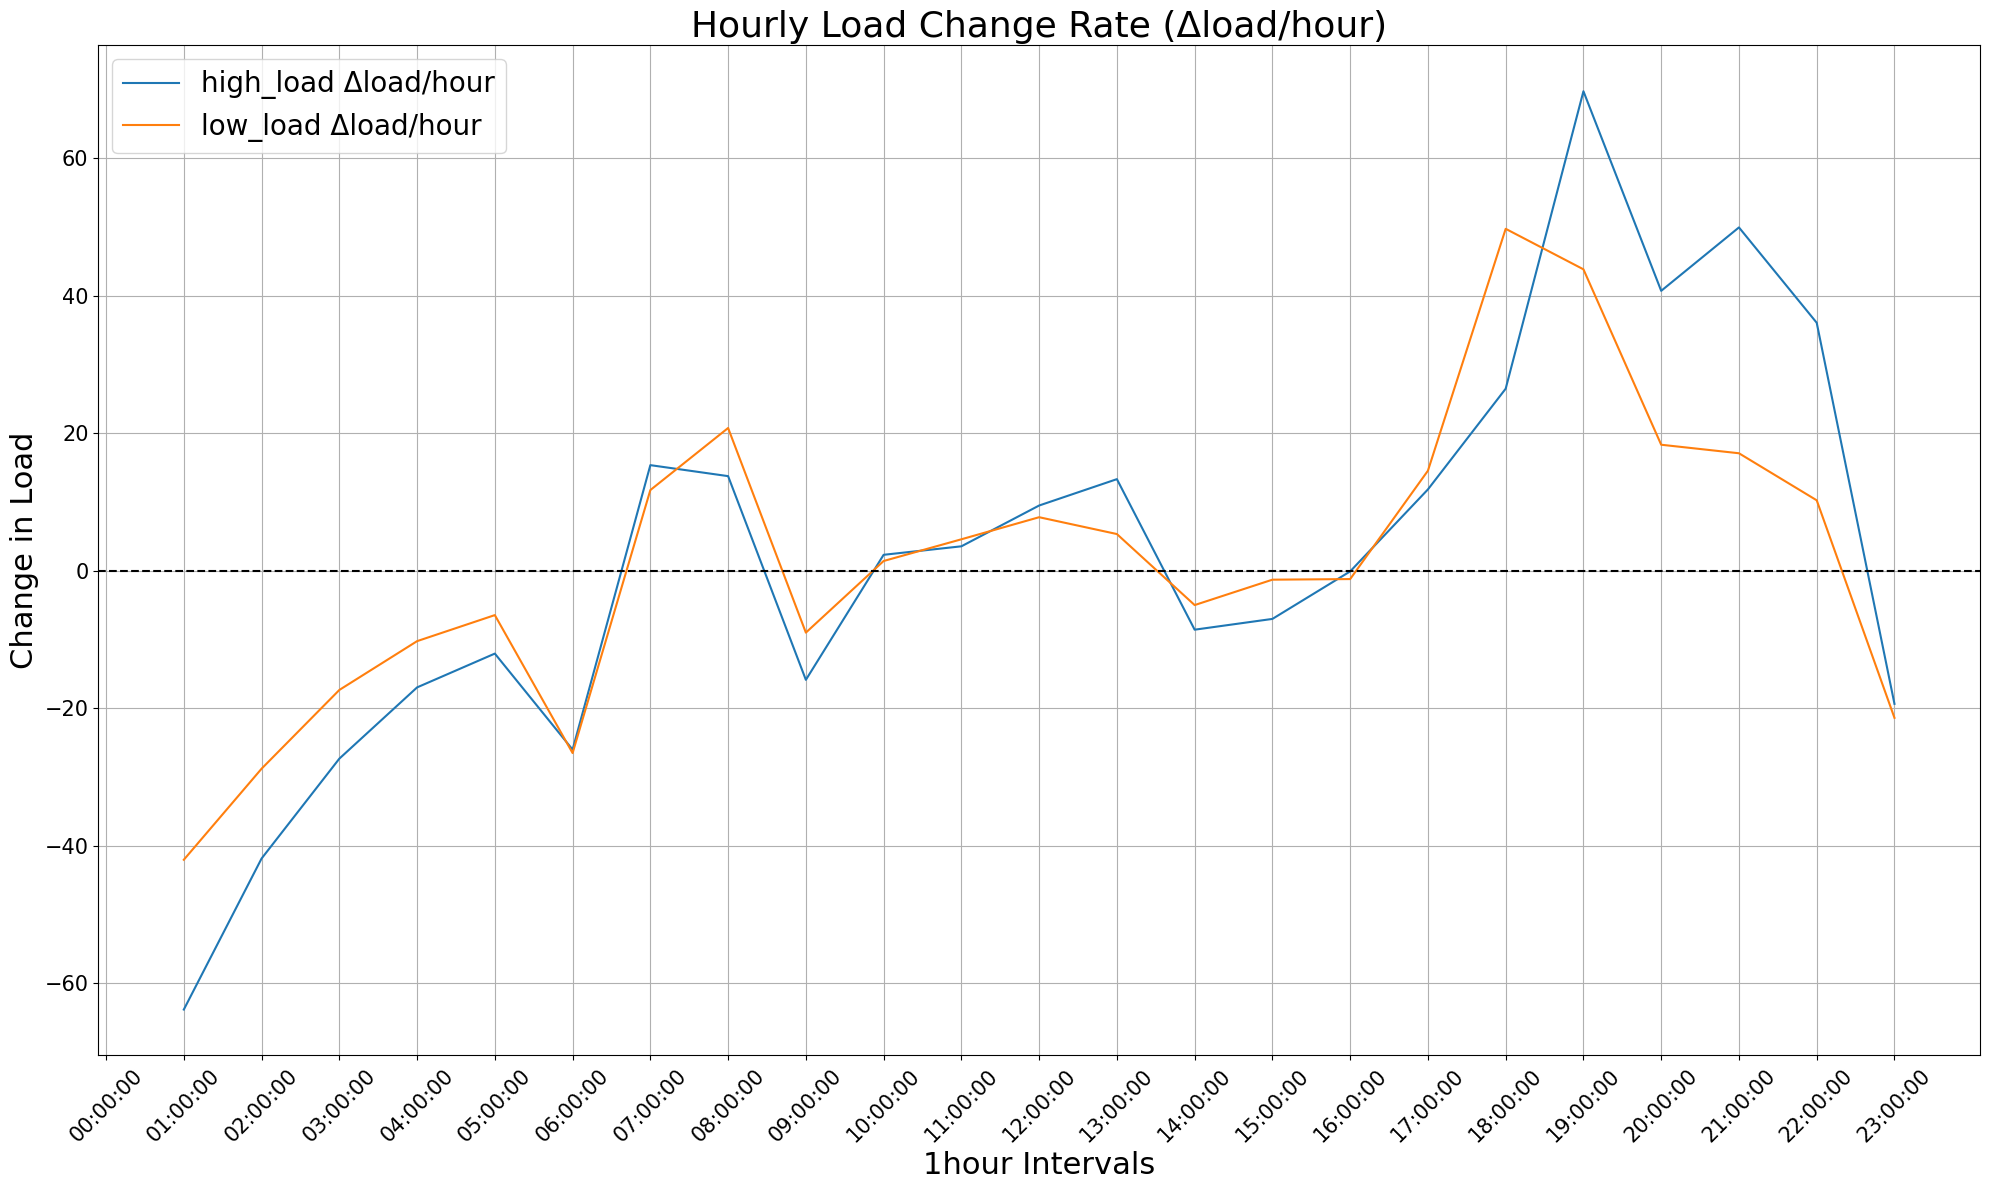

In [59]:
#最大斜率

load_columns = pivot_df_interp.select_dtypes(include='number').columns
load_columns = [col for col in load_columns if col not in ['cluster']]  

# 计算均值
mean_by_label = pivot_df_interp.groupby("pattern")[load_columns].mean()

# 计算每小时变化率（差分）
slope_by_label = mean_by_label.diff(axis=1)

# 绘图：显示每小时变化率
plt.figure(figsize=(20, 12))

for pattern in slope_by_label.index:
    plt.plot(slope_by_label.columns, slope_by_label.loc[pattern], label=f"{pattern} Δload/hour")

plt.axhline(0, color='black', linestyle='--')
plt.title("Hourly Load Change Rate (Δload/hour)", fontsize=26)
plt.xlabel("1hour Intervals", fontsize=22)
plt.ylabel("Change in Load", fontsize=22)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()


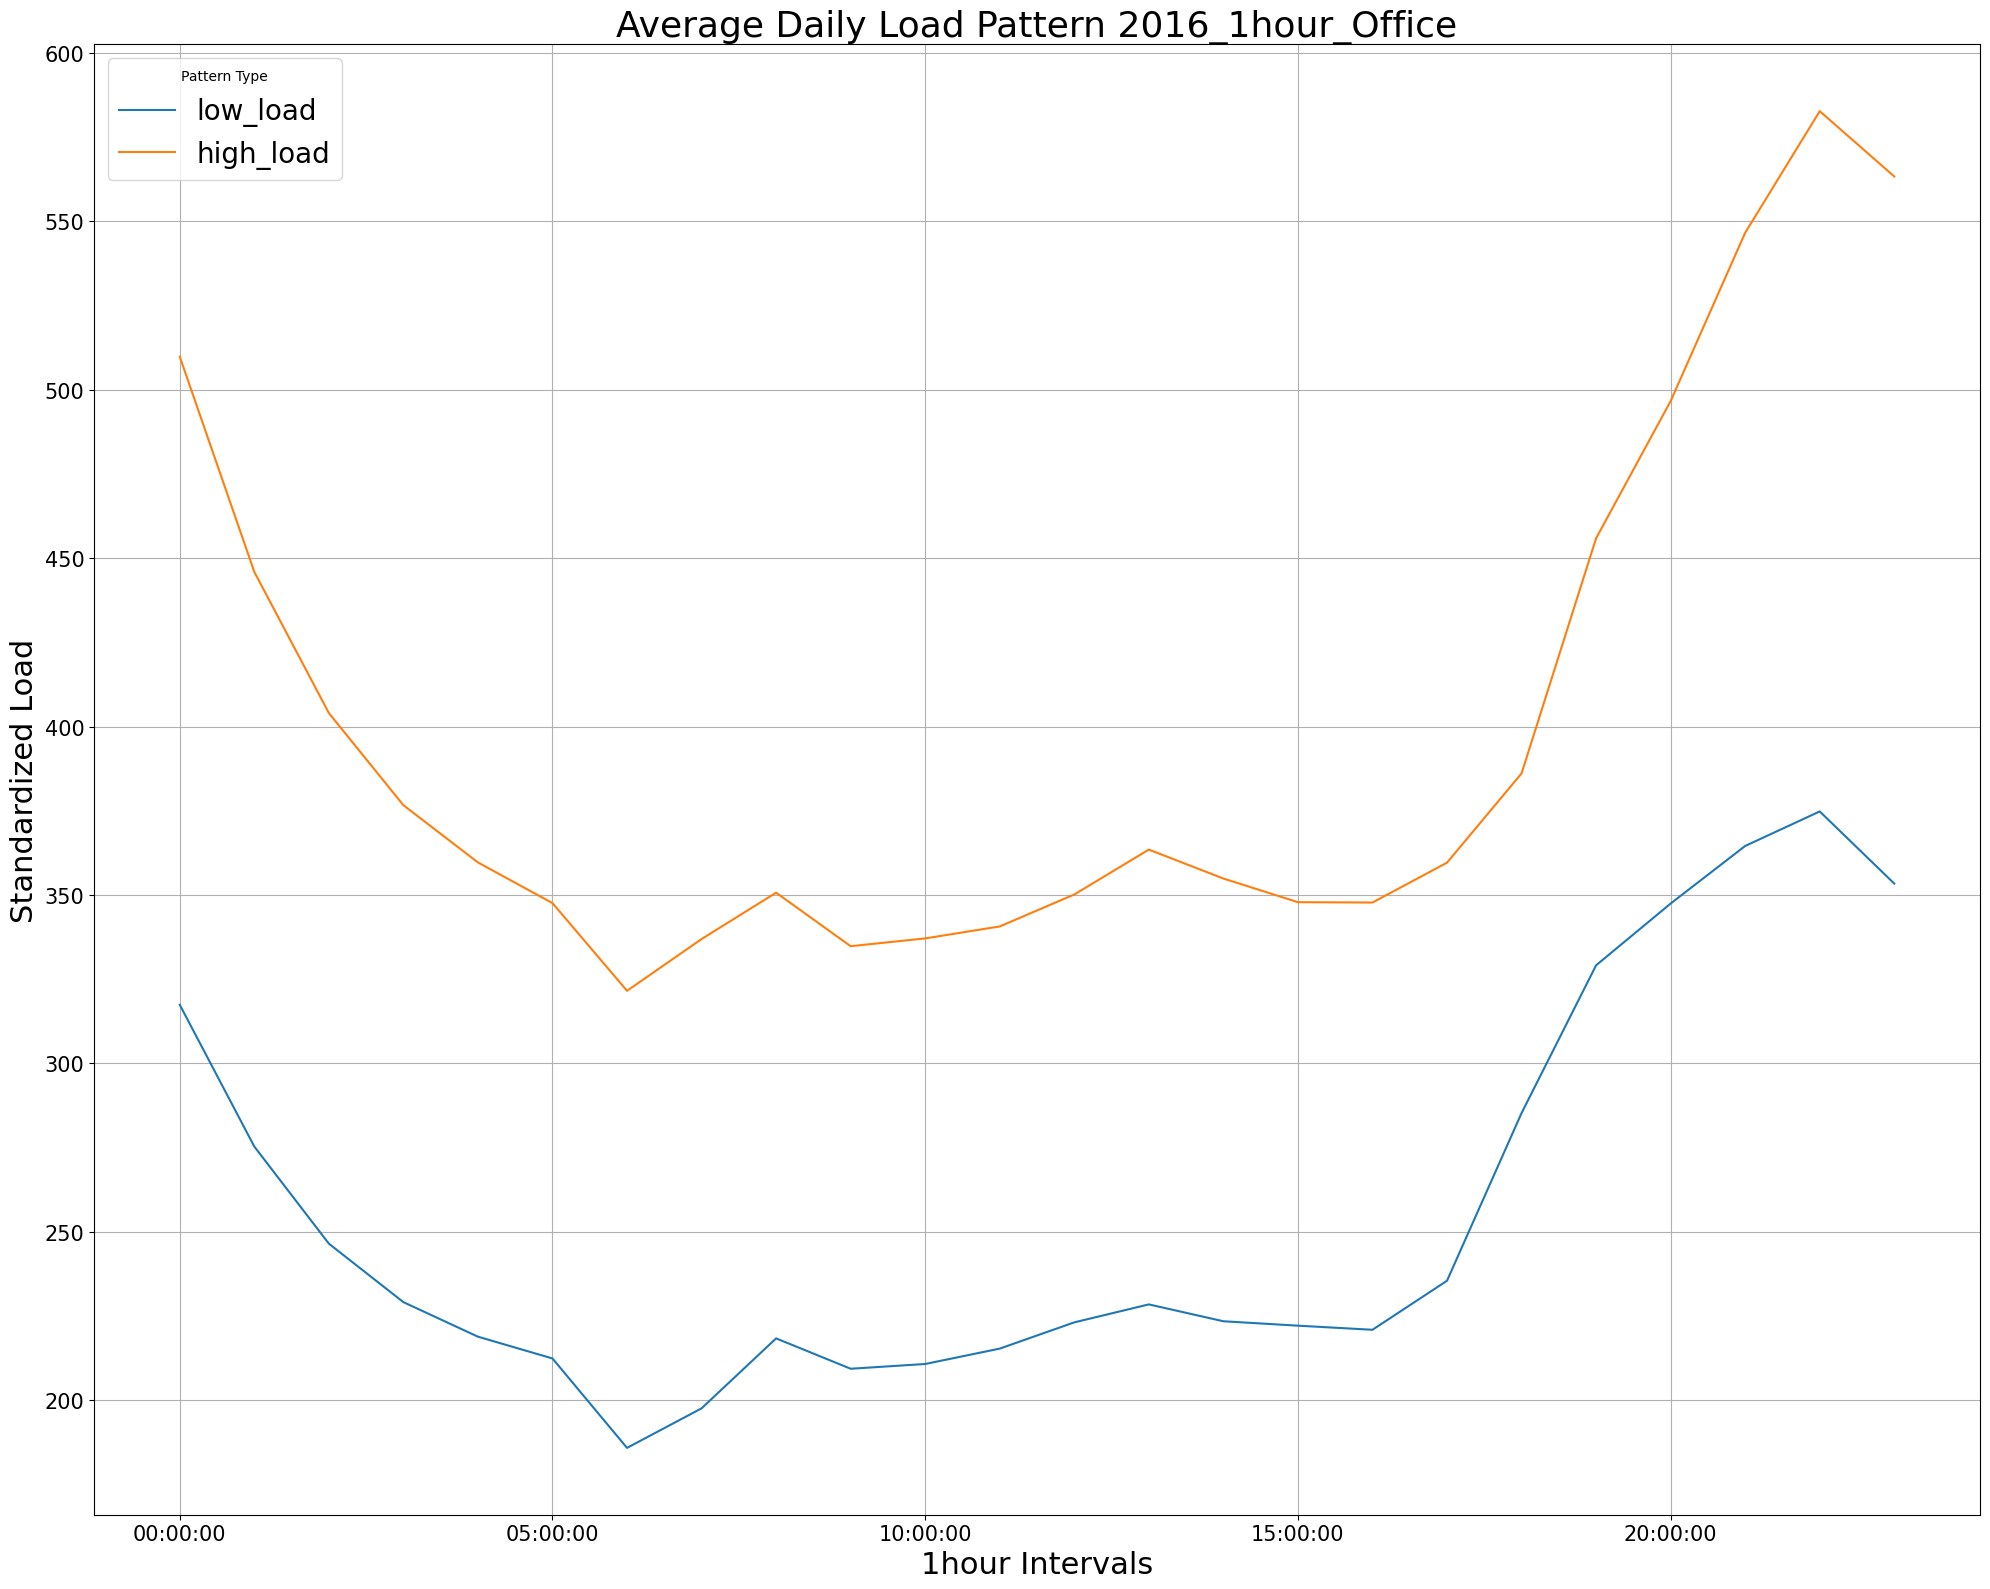

In [60]:
load_columns = pivot_df_interp.select_dtypes(include='number').columns.drop('cluster')

# Ensure clustering has been done and column exists
assert 'cluster' in pivot_df_interp.columns, "Missing 'cluster' column. Run KMeans first."

# Group by cluster, average the first 96 load columns
avg_by_label = pivot_df_interp.groupby("cluster")[load_columns].mean()

# Define custom labels
cluster_name_map = {
    0: "low_load",
    1: "high_load",
    2: "moderate_load"
}
pivot_df_interp['pattern'] = pivot_df_interp['cluster'].map(cluster_name_map)
# Rename cluster index to meaningful names
avg_by_label.index = avg_by_label.index.map(cluster_name_map)

# Plot
avg_by_label.T.plot(figsize=(20, 16))
plt.title("Average Daily Load Pattern 2016_1hour_Office", fontsize=26)
plt.xlabel("1hour Intervals", fontsize=22)
plt.ylabel("Standardized Load", fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(title="Pattern Type", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
cluster_name_map = {
    0: "low_load",
    1: "high_load",
    2: "moderate_load"
}

for c in sorted(pivot_df_interp['cluster'].unique()):
    name = cluster_name_map[c]
    print(f"\nCluster {c} ({name}):")
    dates = pivot_df_interp[pivot_df_interp['cluster'] == c]['date'].tolist()
    print(dates[:10])


Cluster 0 (low_load):
['2016-02-03', '2016-02-04', '2016-02-05', '2016-02-06', '2016-02-07', '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12']

Cluster 1 (high_load):
['2016-01-13', '2016-01-23', '2016-03-13', '2016-07-07', '2016-07-08', '2016-07-09', '2016-07-10', '2016-07-11', '2016-07-12', '2016-07-13']

Cluster 2 (moderate_load):
['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08', '2016-01-09', '2016-01-10']


In [11]:
pivot_df_interp.to_csv("daily_load_with_clusters_and_labels.csv")

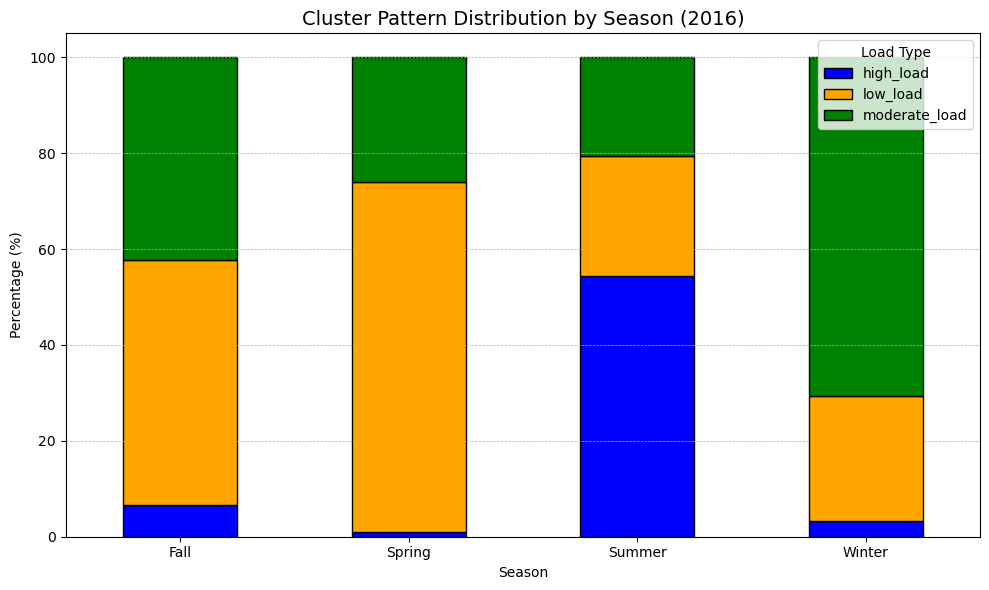

In [17]:
pivot_df = pd.read_csv("daily_load_with_clusters_and_labels_2016_Residential.csv")

# Step 1: Clean columns
pivot_df.columns = [col.strip() for col in pivot_df.columns]
pivot_df['date'] = pd.to_datetime(pivot_df['date'])

# Step 2: Extract features (hourly load only)
load_columns = pivot_df.columns.drop('date')
X = pivot_df[load_columns]

# Step 3: Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
pivot_df['cluster'] = kmeans.fit_predict(X_scaled)

# Optional: Map cluster index to names
cluster_name_map = {
    0: "low_load",
    1: "high_load",
    2: "moderate_load"
}
pivot_df['pattern'] = pivot_df['cluster'].map(cluster_name_map)

# Step 5: Assign season
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

pivot_df['season'] = pivot_df['date'].apply(get_season)

cluster_pct = cluster_pct[['high_load', 'low_load', 'moderate_load']]

color_map = {
    'high_load': 'blue',
    'low_load': 'orange',
    'moderate_load': 'green'
}
colors = [color_map[col] for col in cluster_pct.columns]


# Step 6: Group by season and pattern
cluster_counts = pivot_df.groupby(['season', 'pattern']).size().unstack(fill_value=0)
cluster_pct = cluster_counts.div(cluster_counts.sum(axis=1), axis=0) * 100

# Step 7: Plot
ax = cluster_pct.plot(kind='bar', stacked=True, figsize=(10, 6), edgecolor='black', color=colors)
plt.title('Cluster Pattern Distribution by Season (2016)', fontsize=14)
plt.ylabel('Percentage (%)')
plt.xlabel('Season')
plt.xticks(rotation=0)
plt.legend(title='Load Type')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [13]:
print(df.columns)

Index(['low_load', 'moderate_load', 'high_load'], dtype='object')


/var/folders/08/rpjm2t995s9f7292w_tjt6740000gn/T/ipykernel_38543/222239606.py:25: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/08/rpjm2t995s9f7292w_tjt6740000gn/T/ipykernel_38543/222239606.py:25: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


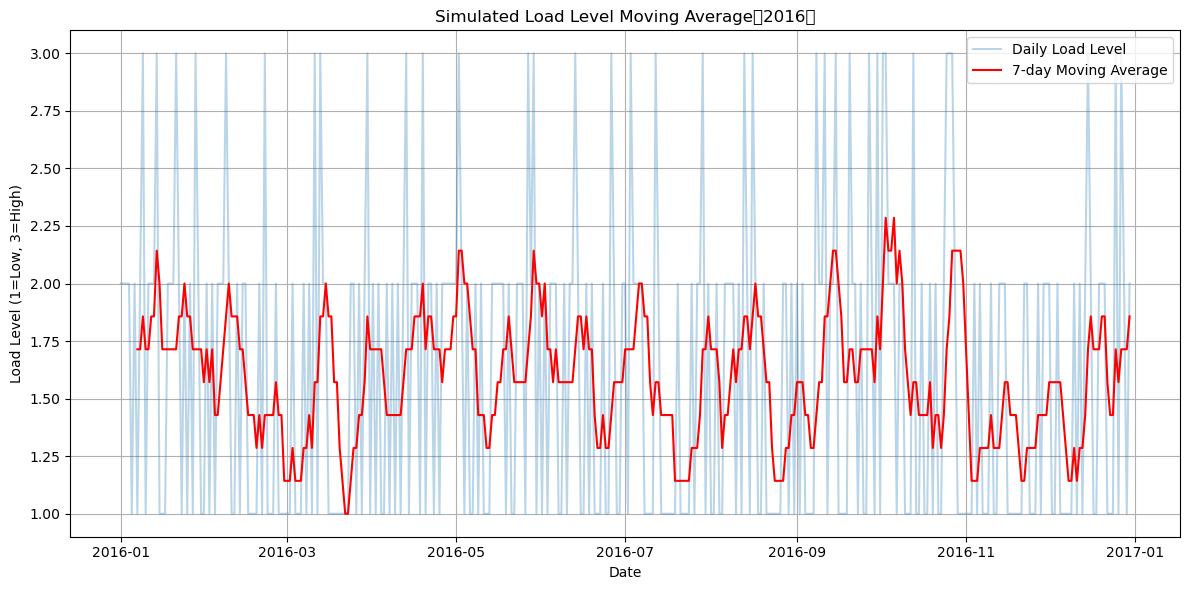

In [32]:
# Simulate 365 days of data
np.random.seed(0)
dates = pd.date_range(start='2016-01-01', periods=365)

# Simulate categories
load_categories = np.random.choice(['low_load', 'moderate_load', 'high_load'], size=365, p=[0.5, 0.4, 0.1])
df = pd.DataFrame({'Date': dates, 'Load_Category': load_categories})

# Map to numeric
load_map = {'low_load': 1, 'moderate_load': 2, 'high_load': 3}
df['Load_Level'] = df['Load_Category'].map(load_map)

# Moving average
df['7_day_MA'] = df['Load_Level'].rolling(window=7).mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Load_Level'], alpha=0.3, label='Daily Load Level')
plt.plot(df['Date'], df['7_day_MA'], color='red', label='7-day Moving Average')
plt.title('Simulated Load Level Moving Average（2016）')
plt.xlabel('Date')
plt.ylabel('Load Level (1=Low, 3=High)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
pivot_df_interp['date'] = pd.to_datetime(pivot_df_interp['date'])

def get_season(date):
    m = date.month
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

pivot_df_interp['season'] = pivot_df_interp['date'].apply(get_season)
pattern_by_season = pivot_df_interp.groupby(['season', 'pattern']).size().unstack(fill_value=0)

seasons = pattern_by_season.index.tolist()
labels = pattern_by_season.columns.tolist()

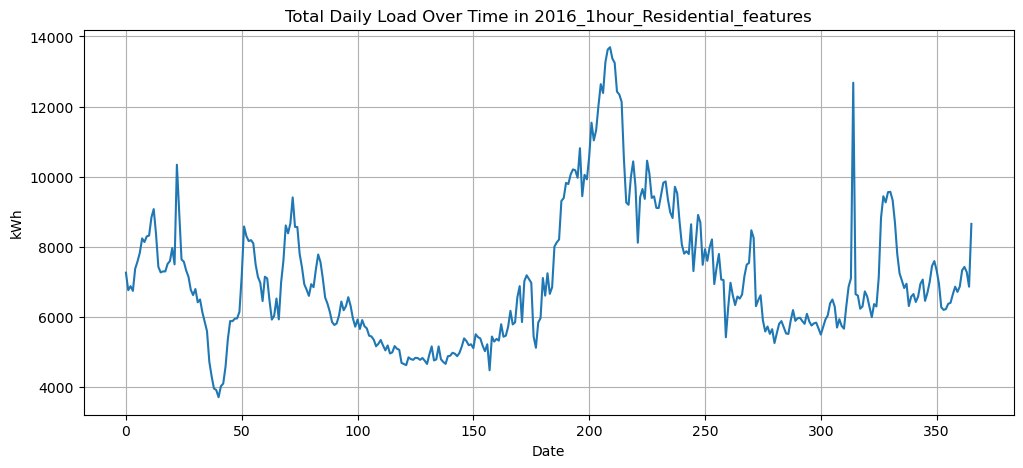

In [57]:
pivot_df_interp['date'] = pd.to_datetime(pivot_df_interp['date'])

# 1. 完成所有预处理（插值、聚类、添加 pattern 和 season）
pivot_df_interp['pattern'] = pivot_df_interp['cluster'].map(cluster_name_map)
pivot_df_interp['season'] = pivot_df_interp['date'].apply(get_season)

# 2. 必须在这里清洗列名！所有后续都基于它！
pivot_df_interp.columns = pivot_df_interp.columns.map(str)

# 3. 抓负载列（非 date / cluster / pattern / season）
load_columns = [col for col in pivot_df_interp.columns if col not in ['date', 'cluster', 'pattern', 'season']]

# 4. 提取特征（注意 idxmax 前，列名必须是 string）
features_df = pd.DataFrame(index=pivot_df_interp.index)
features_df["total_load"] = pivot_df_interp[load_columns].sum(axis=1)
features_df["peak_load"] = pivot_df_interp[load_columns].max(axis=1)
features_df["valley_load"] = pivot_df_interp[load_columns].min(axis=1)
features_df["load_range"] = features_df["peak_load"] - features_df["valley_load"]
features_df["load_std"] = pivot_df_interp[load_columns].std(axis=1)
features_df["time_of_peak"] = pivot_df_interp[load_columns].idxmax(axis=1)
features_df["time_of_valley"] = pivot_df_interp[load_columns].idxmin(axis=1)

# 5.把时间截干净
features_df["time_of_peak"] = features_df["time_of_peak"].str[-8:]
features_df["time_of_valley"] = features_df["time_of_valley"].str[-8:]
features_df["total_load"].plot(figsize=(12, 5), title="Total Daily Load Over Time in 2016_1hour_Residential_features")
plt.xlabel("Date")
plt.ylabel("kWh")
plt.grid(True)
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


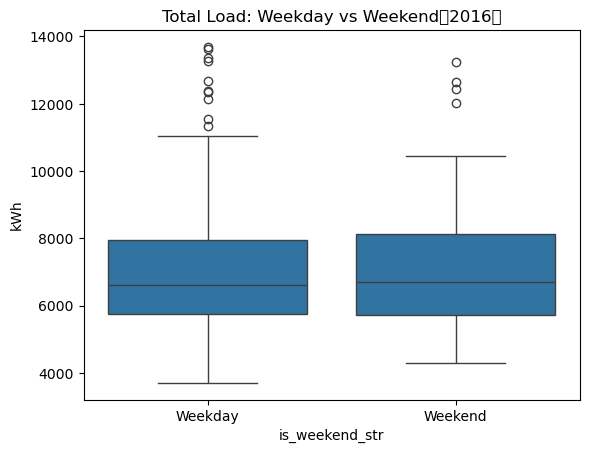

In [58]:
features_df['is_weekend'] = pivot_df_interp['date'].dt.weekday >= 5
features_df['is_weekend_str'] = features_df['is_weekend'].map({True: 'Weekend', False: 'Weekday'})
features_df["is_weekend_str"] = features_df["is_weekend"].map({True: "Weekend", False: "Weekday"})
sns.boxplot(x="is_weekend_str", y="total_load", data=features_df)
plt.title("Total Load: Weekday vs Weekend（2016）")
plt.ylabel("kWh")
plt.show()

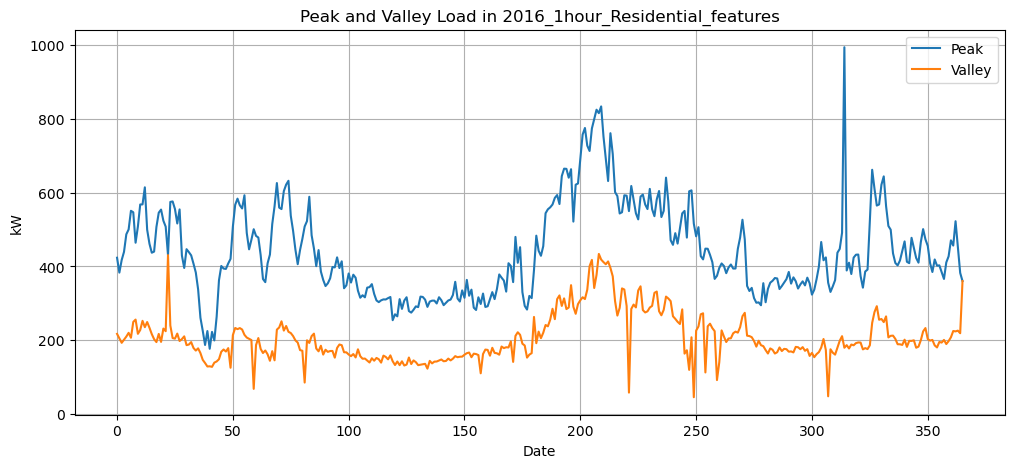

In [62]:
features_df[["peak_load", "valley_load"]].plot(figsize=(12, 5), title="Peak and Valley Load in 2016_1hour_Residential_features")
plt.xlabel("Date")
plt.ylabel("kW")
plt.legend(["Peak", "Valley"])
plt.grid(True)
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


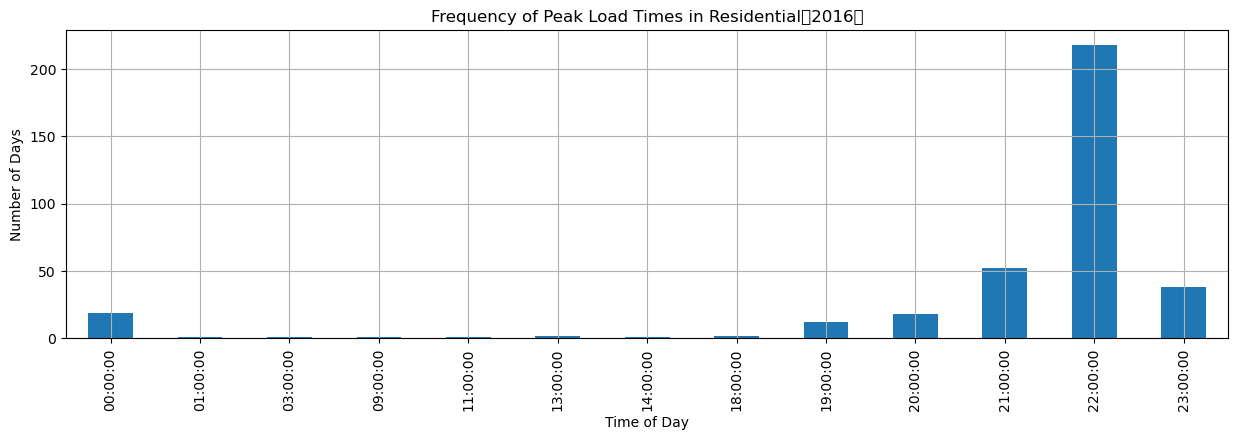

In [60]:
features_df["time_of_peak"].value_counts().sort_index().plot(kind="bar", figsize=(15, 4), title="Frequency of Peak Load Times in Residential（2016）")
plt.xlabel("Time of Day")
plt.ylabel("Number of Days")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

/var/folders/08/rpjm2t995s9f7292w_tjt6740000gn/T/ipykernel_25171/289940946.py:17: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/08/rpjm2t995s9f7292w_tjt6740000gn/T/ipykernel_25171/289940946.py:17: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1600x1000 with 0 Axes>

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


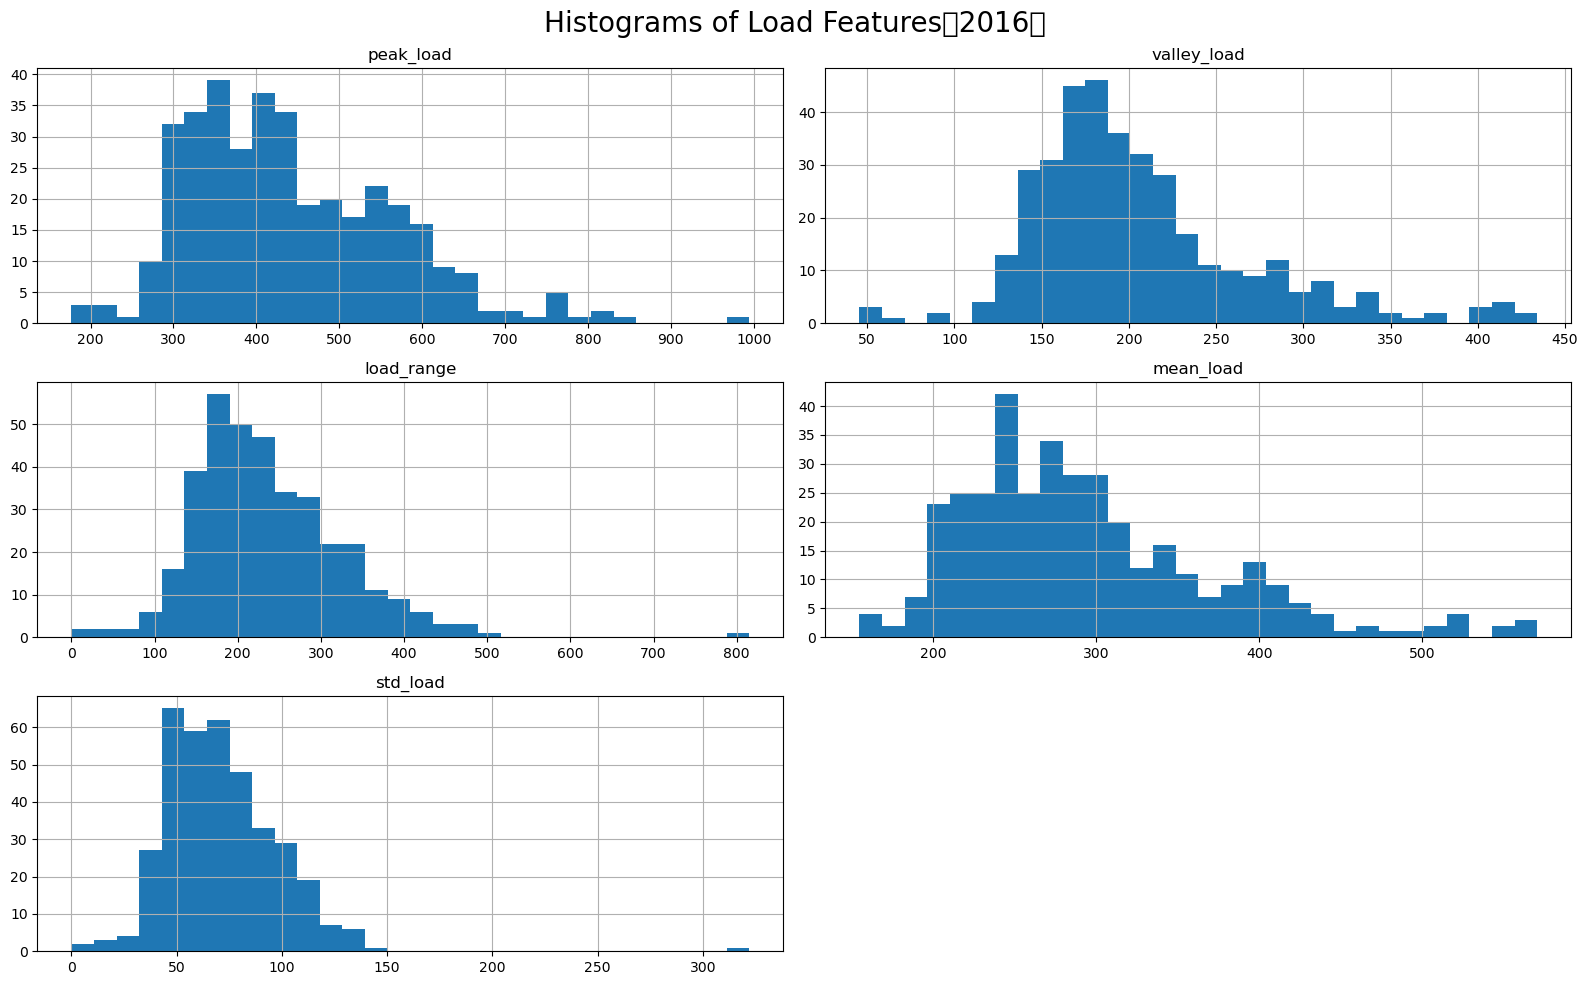

In [61]:
feature_df = pd.DataFrame(index=pivot_df_interp.index)

# 选择中间的负载列（避开 date, cluster 等）
load_columns = [col for col in pivot_df_interp.columns if col not in ['date', 'cluster', 'pattern', 'season']]

feature_df['peak_load'] = pivot_df_interp[load_columns].max(axis=1)
feature_df['valley_load'] = pivot_df_interp[load_columns].min(axis=1)
feature_df['load_range'] = feature_df['peak_load'] - feature_df['valley_load']
feature_df['mean_load'] = pivot_df_interp[load_columns].mean(axis=1)
feature_df['std_load'] = pivot_df_interp[load_columns].std(axis=1)
feature_df['load_factor'] = feature_df['mean_load'] / feature_df['peak_load']
feature_df['peak_time'] = pivot_df_interp[load_columns].idxmax(axis=1)
feature_df['valley_time'] = pivot_df_interp[load_columns].idxmin(axis=1)
plt.figure(figsize=(16, 10))
feature_df[['peak_load', 'valley_load', 'load_range', 'mean_load', 'std_load']].hist(bins=30, figsize=(16, 10))
plt.suptitle("Histograms of Load Features（2016）", fontsize=20)
plt.tight_layout()
plt.show()